<!--NOTEBOOK_HEADER-->
*This notebook contains material from [Controlling Natural Watersheds](https://jckantor.github.io/Controlling-Natural-Watersheds);
content is available [on Github](https://github.com/jckantor/Controlling-Natural-Watersheds.git).*

<!--NAVIGATION-->
< [Ice Out Dates](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.08-Ice_Out_Dates.ipynb) | [Contents](toc.ipynb) | [Rainy River Flows](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.20-Rainy_River_Flows.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.09-USGS Surface Water Daily Data.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.09-USGS Surface Water Daily Data.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# USGS Surface Water Daily Data

Retrieve historical [daily data](http://waterdata.usgs.gov/nwis/dv/)from [National Water Information System](http://waterdata.usgs.gov/nwis/sw).

### Table of Contents

* [Initialization](#Initialization)



<a id="Initialization"></a>
## Initialization and Loading of USGS Data Tables

USGS Site  | Description | Start | End |
---------- | ----------- | ----- | --- |
[05129115](http://waterdata.usgs.gov/nwis/dv/?site_no=05129115&agency_cd=USGS) | VERMILION RIVER NR CRANE LAKE, MN | 1979-08-01 | 2016-08-09
[05131500](http://waterdata.usgs.gov/nwis/dv/?site_no=05131500&agency_cd=USGS) | LITTLE FORK RIVER AT LITTLEFORK, MN 
[05132000](http://waterdata.usgs.gov/nwis/dv/?site_no=05132000&agency_cd=USGS) | BIG FORK RIVER AT BIG FALLS, MN



In [49]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import requests

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

In [85]:
def USGS_Flow(s):
    userdata = {'cb_00060':'on',
           'format' : 'rdb',
           'site_no' : s, 
           'begin_date' : '1970-01-01',
           'end_date' : '2014-12-31'}

    resp = requests.get('http://waterdata.usgs.gov/nwis/dv', userdata)
    
    station_number = ' '.join(resp.text.split('\n')[14:15][0][1:].split()[0:2])
    station_name = ' '.join(resp.text.split('\n')[14:15][0][1:].split()[2:])

    data = [line.split('\t')[2:4] for line in resp.text.split('\n') if line[0:4]=='USGS']
    data = [d for d in data if d[1]]
    flow = pd.Series([float(d[1]) for d in data], index=pd.to_datetime([d[0] for d in data]))

    return station_number, station_name, flow


STATION_NUMBER, STATION_NAME, FLOW = USGS_Flow('05132000')

In [91]:
def USGS_FlowFrequency(s):
    
    station_number, station_name, FLOW = USGS_Flow(s)

    FLOW = FLOW['1970':]
    # select period of year
    FLOW = FLOW.ix[FLOW.index.dayofyear >= 1] # 135]
    FLOW = FLOW.ix[FLOW.index.dayofyear <= 366] # 196]

    # show data
    plt.figure(figsize=(12,8))
    plt.subplot2grid((2,2),(0,0),colspan=2)
    plt.plot(FLOW[:'1999'],color='b')
    plt.hold(True)
    plt.plot(FLOW['2000':],color='g')    
    plt.xlabel('Year')
    plt.ylabel('Flow [cubic meters/second]')
    plt.title(s + ': ' + station_name + 
              ' ' + str(FLOW.index[0].year) + '-' + str(FLOW.index[-1].year))
    
    # histogram distribution of flows
    plt.subplot2grid((2,2),(1,0))
    plt.hold(True)
    hist,bins = np.histogram(FLOW,bins=100)
    FLOW['1970':'1999'].hist(bins=bins,normed=1, color='b', alpha=0.5)
    FLOW['2000':].hist(bins=bins,normed=1,color='g', alpha=0.5)
    plt.ylabel('Frequency')
    plt.xlabel('Flow [cubic meters/second]')
    plt.legend(['1970-1999','2000-2014'])
    plt.tight_layout()
    
    # flow-frequency plots
    plt.subplot2grid((2,2),(1,1))
    plt.hold(True)
    hist,bins = np.histogram(FLOW['1970':'1999'],bins = 100)
    chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
    plt.semilogy(bins[1:],chist)
    hist,bins = np.histogram(FLOW['2000':],bins = 100)
    chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
    plt.semilogy(bins[1:],chist,color='g')
    plt.xlim([0,plt.xlim()[1]])
    plt.legend(['1970-1999','2000-2014'])
    plt.title('Probability of Exceeding a Given Flowrate')
    plt.xlabel('Flow [cubic feet/sec]')

    plt.hold(False)
    plt.grid()
    plt.tight_layout()
    
    fname = '../images/FlowFrequency_' + s + '.png'
    plt.savefig(fname)
    !convert $fname -trim $fname

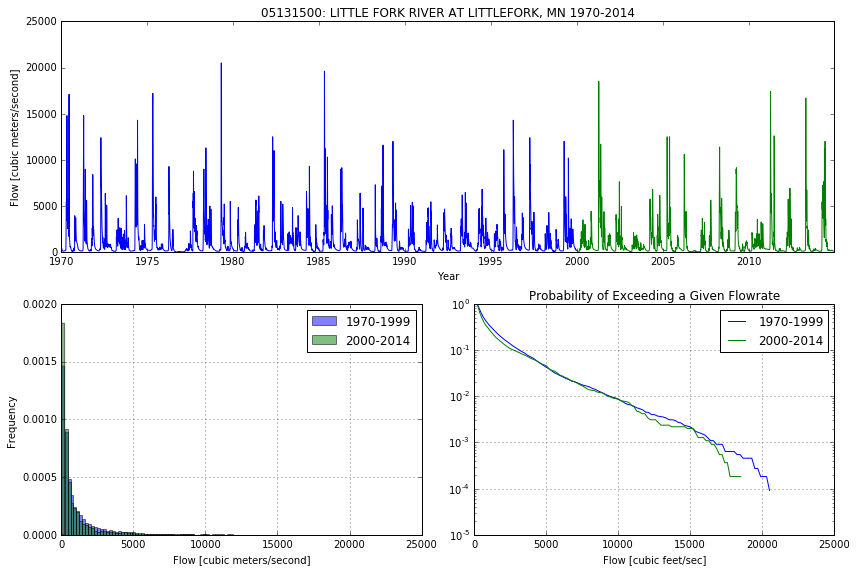

In [92]:
USGS_FlowFrequency('05131500')

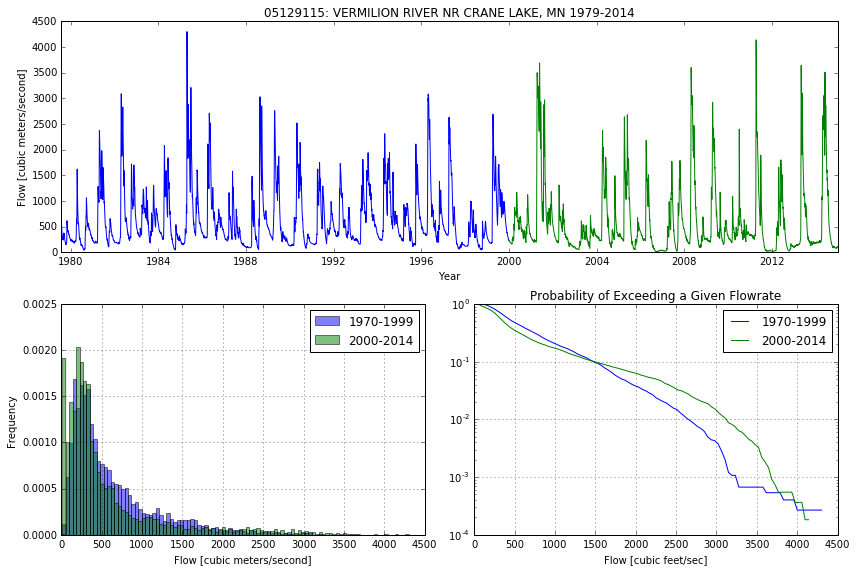

In [93]:
USGS_FlowFrequency('05129115')

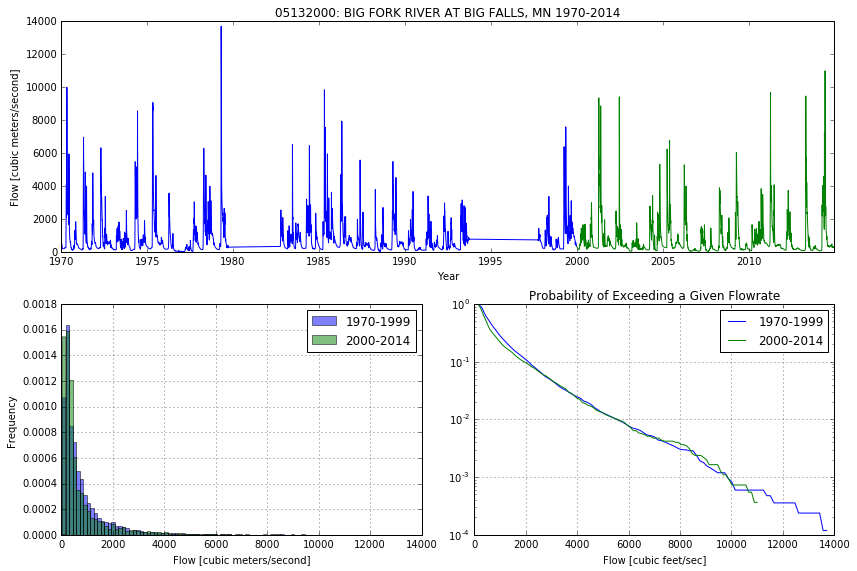

In [94]:
USGS_FlowFrequency('05132000')

In [66]:
# Read data files as a pandas dataframes
STATIONS = pd.read_csv(HYDAT_dir + 'STATIONS.csv', index_col = 0);
DLY_LEVELS = pd.read_csv(HYDAT_dir + 'DLY_LEVELS.csv')
DLY_FLOWS = pd.read_csv(HYDAT_dir + 'DLY_FLOWS.csv')

print "    Stations in the HYDAT database = ", len(STATIONS.index)

    Stations in the HYDAT database =  7775


<a id="Monitoring Stations"></a>
## Monitoring Stations in the Rainy River Watershed

The following cell creates a pandas dataframe of monitoring stations from the STATIONS.csv table extracted from the HYDAT database. The extaction searches for all stations with a specified region bounded by latitude and longitudes.

For reference, this is a map of the [Rainy River drainage](http://www.ijc.org/files/tinymce/uploaded/rl_basinmap.pdf) basin available from the International Joint Commission. 

<p align='center'><img src='../images/75242923.png' width = 480></p>

In [67]:
# bounding region
lngW = -94.0
lngE = -90.5
latS = 47.5
latN = 49.0

# locate monitoring stations within bounding region
stationList = STATIONS[(STATIONS['LATITUDE'] >= latS) & \
         (STATIONS['LATITUDE'] <= latN) & \
         (STATIONS['LONGITUDE'] <= lngE) & \
         (STATIONS['LONGITUDE'] >= lngW)].index

# reduce data sets to the area of interest
WSC_STATIONS = STATIONS.ix[stationList]
DLY_LEVELS = DLY_LEVELS.ix[[idx for idx in DLY_LEVELS.index if DLY_LEVELS.ix[idx,'STATION_NUMBER'] in stationList]]
DLY_FLOWS = DLY_FLOWS.ix[[idx for idx in DLY_FLOWS.index if DLY_FLOWS.ix[idx,'STATION_NUMBER'] in stationList]]

# add columns to STATIONS for level and flow stations
WSC_STATIONS['Level'] = ''
WSC_STATIONS['Flow'] = ''

# mark level and flow stations
WSC_STATIONS.ix[set(DLY_LEVELS['STATION_NUMBER']).intersection(WSC_STATIONS.index),'Level'] = True
WSC_STATIONS.ix[set(DLY_FLOWS['STATION_NUMBER']).intersection(WSC_STATIONS.index),'Flow'] = True

print "Stations within region of interest = ", len(WSC_STATIONS.index)
print "DLY_FLOWS records = ", len(DLY_FLOWS.index)
print "DLY_LEVELS records = ", len(DLY_LEVELS.index)
display(WSC_STATIONS.ix[:,['Level','Flow','STATION_NAME','LATITUDE','LONGITUDE',]])

WSC_STATIONS.to_pickle('../data/WSC_STATIONS')

Stations within region of interest =  34
DLY_FLOWS records =  7965
DLY_LEVELS records =  5913


Level  Flow                                      STATION_NAME  \
STATION_NUMBER                                                                 
05PA001               True                   KETTLE RIVER ABOVE KETTLE FALLS   
05PA003         True                     NAMAKAN LAKE ABOVE KETTLE FALLS DAM   
05PA005         True                           NORTHERN LIGHT LAKE AT OUTLET   
05PA006         True  True           NAMAKAN RIVER AT OUTLET OF LAC LA CROIX   
05PA007         True                         CROOKED LAKE NEAR CURTAIN FALLS   
05PA010         True                               FRENCH LAKE NEAR ATIKOKAN   
05PA011         True                         LAC LA CROIX AT CAMPBELL'S CAMP   
05PA012         True  True                        BASSWOOD RIVER NEAR WINTON   
05PA013         True                         NAMAKAN LAKE AT SQUIRREL ISLAND   
05PB001               True                         SEINE RIVER NEAR LA SEINE   
05PB002         True                     LITTLE TURTLE LAKE NEAR MINE CENTRE   
05PB003               True               MANITOU RIVER ABOVE DEVIL'S CASCADE   
05PB004               True               FOOTPRINT RIVER AT RAINY LAKE FALLS   
05PB007         True                            RAINY LAKE NEAR FORT FRANCES   
05PB009               True  SEINE RIVER AT STURGEON FALLS GENERATING STATION   
05PB012         True                     LAC DES MILLE LACS ABOVE OUTLET DAM   
05PB014         True  True                     TURTLE RIVER NEAR MINE CENTRE   
05PB015               True                  PIPESTONE RIVER ABOVE RAINY LAKE   
05PB018         True  True                        ATIKOKAN RIVER AT ATIKOKAN   
05PB019               True  NORTHEAST TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN   
05PB020               True    EASTERN TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN   
05PB021               True    EYE RIVER NEAR HARDTACK LAKE NORTH OF ATIKOKAN   
05PB022               True     EYE RIVER NEAR COULSON LAKE NORTH OF ATIKOKAN   
05PB023         True                             RAINY LAKE AT NORTHWEST BAY   
05PB024         True                               RAINY LAKE NEAR BEAR PASS   
05PB025         True                                RAINY LAKE AT STOKES BAY   
05PC009               True                      LA VALLEE RIVER AT LA VALLEE   
05PC010               True                       STURGEON RIVER NEAR BARWICK   
05PC016               True                       LA VALLEE RIVER NEAR DEVLIN   
05PC018         True  True                     RAINY RIVER AT MANITOU RAPIDS   
05PC019               True                       RAINY RIVER AT FORT FRANCES   
05PC022         True  True                      LA VALLEE RIVER NEAR BURRISS   
05PC024         True                  RAINY RIVER AT PITHERS POINT SITE NO.1   
05PC025         True                  RAINY RIVER AT PITHERS POINT SITE NO.2   

                LATITUDE  LONGITUDE  
STATION_NUMBER                       
05PA001         48.49444  -92.64444  
05PA003         48.50000  -92.63886  
05PA005         48.24028  -90.76889  
05PA006         48.38256  -92.17631  
05PA007         48.23750  -91.90611  
05PA010         48.67222  -91.13500  
05PA011         48.35508  -92.21744  
05PA012         48.08256  -91.65117  
05PA013         48.49686  -92.65856  
05PB001         48.75000  -92.20000  
05PB002         48.77222  -92.60833  
05PB003         48.97500  -93.34167  
05PB004         48.85833  -93.57500  
05PB007         48.64912  -93.32068  
05PB009         48.74444  -92.28472  
05PB012         48.98000  -90.73000  
05PB014         48.85022  -92.72383  
05PB015         48.56861  -92.52417  
05PB018         48.75197  -91.58408  
05PB019         48.95083  -91.71222  
05PB020         48.94056  -91.69833  
05PB021         48.92500  -91.66222  
05PB022         48.89444  -91.66750  
05PB023         48.84167  -93.62000  
05PB024         48.70058  -92.95800  
05PB025         48.53611  -92.56111  
05PC009         48.62083  -93.62500  
05PC010         48.68750  -93.98

<a id='mapping'></a>
### Mapping WSC Stations

The following function maps a list of stations identified by their station numbers. In extracts latitude and longitude from the STATIONS table, then calls the google maps web api to create a map image.

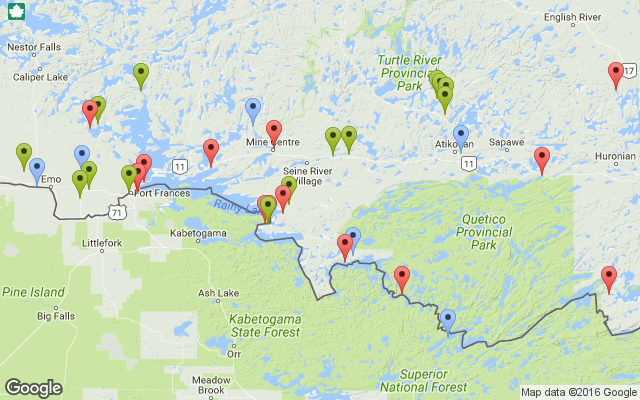

In [69]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')

def mapWSC(stationList,zoom=8):
    # returns a .png map image        
    locs = ["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], WSC_STATIONS.ix[s,'LONGITUDE']) \
             for s in stationList]
    
    flows = [s for s in stationList if WSC_STATIONS.ix[s,'Flow'] == True]
    levels = [s for s in stationList if WSC_STATIONS.ix[s,'Level'] == True]
    
    rSet = set(levels).difference(set(flows))
    gSet = set(flows).difference(set(levels))
    bSet = set(levels).intersection(set(flows))

    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x400" + \
        "&zoom={:d}".format(zoom) + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7C" + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in rSet]) + \
        "&markers=color:green%7Csize:mid%7C" + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in gSet]) + \
        "&markers=color:blue%7Csize:mid%7C" + \
        "|".join(["{0},{1}".format(WSC_STATIONS.ix[s,'LATITUDE'], \
                                   WSC_STATIONS.ix[s,'LONGITUDE']) for s in bSet])

    return Image(requests.get(google_maps_url).content)


display(mapWSC(WSC_STATIONS.index))

<a id='WSC_LEVELS'></a>
## Pickle Level Data to WSC_LEVELS

In [25]:
def getLevelsWSC(s):
    '''Return a time series for levels at a given station.'''
    ts = {}   
    data = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'] == s]
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'LEVEL'+str(n)]  
    ts = pd.Series(ts)
    #drop initial and terminal null entries
    j = 0
    while j<len(ts.index) and pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while k>=j and pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k+1]

WSC_LEVELS = pd.DataFrame({s:getLevelsWSC(s) for s in WSC_STATIONS[WSC_STATIONS['Level']==True].index})
WSC_LEVELS.to_pickle('../data/WSC_LEVELS')
WSC_LEVELS.head()

05PA003  05PA005  05PA006  05PA007  05PA010  05PA011  05PA012  \
1911-08-20      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1911-08-21      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1911-08-22      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1911-08-23      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1911-08-24      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            05PA013  05PB002  05PB007  05PB012  05PB014  05PB018  05PB023  \
1911-08-20      NaN      NaN  336.868      NaN      NaN      NaN      NaN   
1911-08-21      NaN      NaN  336.880      NaN      NaN      NaN      NaN   
1911-08-22      NaN      NaN  336.865      NaN      NaN      NaN      NaN   
1911-08-23      NaN      NaN  336.853      NaN      NaN      NaN      NaN   
1911-08-24      NaN      NaN  336.844      NaN      NaN      NaN      NaN   

            05PB024  05PB025  05PC018  05PC022  05PC024  05PC025  
1911-08-20      NaN      NaN      NaN      NaN      NaN      NaN  
1911-08-21      NaN      NaN      NaN      NaN      NaN      NaN  
1911-08-22      NaN      NaN      NaN      NaN      NaN      NaN  
1911-08-23      NaN      NaN      NaN      NaN      NaN      NaN  
1911-08-24      NaN      NaN      NaN      NaN      NaN      NaN

<a id='WSC_FLOWS'></a>
## Pickle Flow Data to WSC_FLOWS

The DLY_FLOW data is encoded in an irregular tabular format where rows are indexed by station code, year, and month, and columns are indexed by date.  Given a station code, the following function decodes DLY_FLOW to produce a pandas times series of flow rates.  The function is used to create a pandas dataframe for all flow stations in WSC_STATIONS, then pickles the results to a data file for use by other notebooks in this repository.

In [26]:
def getFlowsWSC(s):
    ts = {}
    data = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'] == s]
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'FLOW'+str(n)]  
    ts = pd.Series(ts)
    ts.name = s +': ' + STATIONS.ix[s,'STATION_NAME'] + \
        ' from ' + '{0}'.format(ts.index[0].year) + \
        ' to ' + '{0}'.format(ts.index[-1].year)
    #drop initial and terminal null entries
    j = 0
    while j<len(ts.index) and pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while k>=j and pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k+1]

WSC_FLOWS = pd.DataFrame({s: getFlowsWSC(s) for s in WSC_STATIONS[WSC_STATIONS['Flow']==True].index})
WSC_FLOWS.to_pickle('../data/WSC_FLOWS')
WSC_FLOWS.head()

05PA001  05PA006  05PA012  05PB001  05PB003  05PB004  05PB009  \
1905-10-25      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-26      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-27      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-28      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-29      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            05PB014  05PB015  05PB018  05PB019  05PB020  05PB021  05PB022  \
1905-10-25      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-26      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-27      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-28      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1905-10-29      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            05PC009  05PC010  05PC016  05PC018  05PC019  05PC022  
1905-10-25      NaN      NaN      NaN      NaN    399.0      NaN  
1905-10-26      NaN      NaN      NaN      NaN    405.0      NaN  
1905-10-27      NaN      NaN      NaN      NaN    396.0      NaN  
1905-10-28      NaN      NaN      NaN      NaN    394.0      NaN  
1905-10-29      NaN      NaN      NaN      NaN    391.0      NaN

## Use Cases

### Example: Station Data

The HYDAT database is a collection of data associated with monitoring stations located throughout Canada. The STATIONS table contains a list of stations and attributes, including the latitude and longitude of their position. As an example, here we list attributes for 05PB007, a station monitoring the level of Rainy Lake near Fort Frances, Ontario.

In [64]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')

display(WSC_STATIONS.ix['05PB007'])
display(WSC_STATIONS.ix['05PC018'])

STATION_NAME            RAINY LAKE NEAR FORT FRANCES
PROV_TERR_STATE_LOC                               ON
REGIONAL_OFFICE_ID                                 5
HYD_STATUS                                         A
SED_STATUS                                       NaN
LATITUDE                                     48.6491
LONGITUDE                                   -93.3207
DRAINAGE_AREA_GROSS                              NaN
DRAINAGE_AREA_EFFECT                             NaN
RHBN                                               0
REAL_TIME                                          1
CONTRIBUTOR_ID                                   647
OPERATOR_ID                                      647
DATUM_ID                                         100
Level                                           True
Flow                                                
Name: 05PB007, dtype: object

STATION_NAME            RAINY RIVER AT MANITOU RAPIDS
PROV_TERR_STATE_LOC                                ON
REGIONAL_OFFICE_ID                                  5
HYD_STATUS                                          A
SED_STATUS                                        NaN
LATITUDE                                      48.6345
LONGITUDE                                    -93.9134
DRAINAGE_AREA_GROSS                             50200
DRAINAGE_AREA_EFFECT                              NaN
RHBN                                                0
REAL_TIME                                           0
CONTRIBUTOR_ID                                    647
OPERATOR_ID                                       600
DATUM_ID                                           10
Level                                            True
Flow                                             True
Name: 05PC018, dtype: object

### Example: Plotting level and flow information

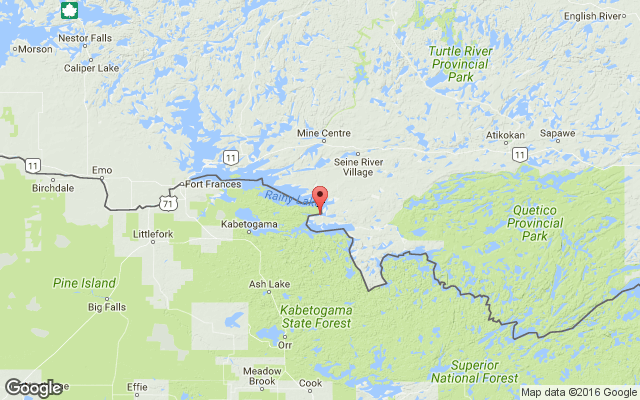

<IPython.core.display.Javascript object>


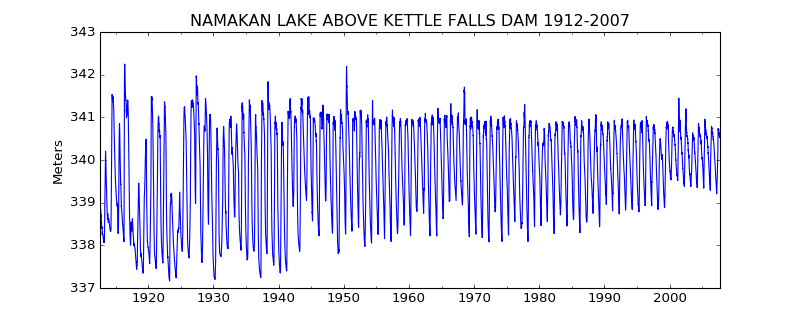

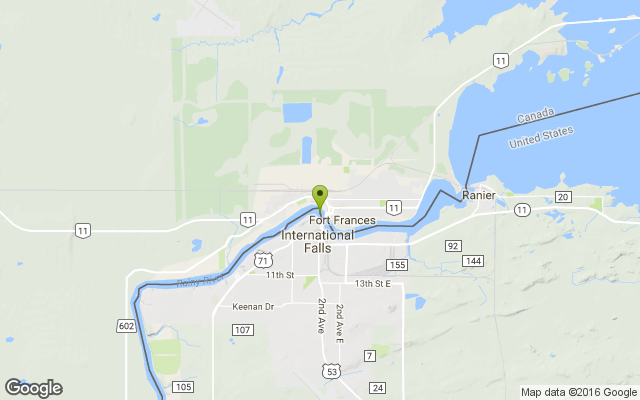

<IPython.core.display.Javascript object>


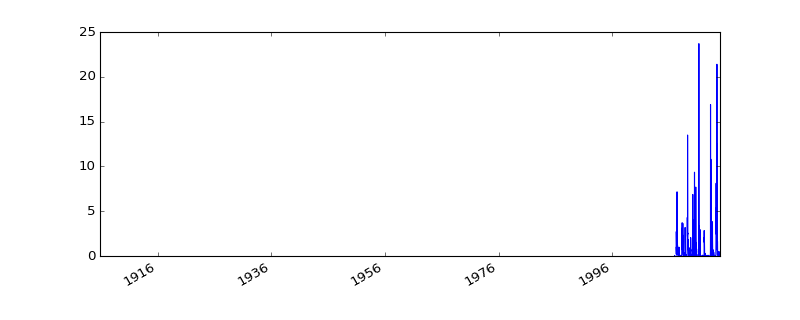

In [75]:
%matplotlib notebook

WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

s = '05PA003'
display(mapWSC([s]))
plt.figure(figsize=(10,4))
WSC_LEVELS[s].dropna().plot()
yrA = str(WSC_LEVELS[s].dropna().index[0].year)
yrB = str(WSC_LEVELS[s].dropna().index[-1].year)
plt.title(WSC_STATIONS.ix[s,'STATION_NAME'] + ' ' + yrA + '-' + yrB) 
plt.ylabel('Meters')

s = '05PC019'
display(mapWSC([s],12))
plt.figure(figsize=(10,4))
WSC_FLOWS[s].dropna().plot()
yrA = str(WSC_FLOWS[s].dropna().index[0].year)
yrB = str(WSC_FLOWS[s].dropna().index[-1].year)
plt.title(WSC_STATIONS.ix[s,'STATION_NAME'] + ' ' + yrA + '-' + yrB) 
plt.ylabel('Cubic Meters per Second')

### Example: Comparing Levels on Rainy and Namakan Lakes

Use of this function is demonstrated by reading and plotting the history of lake levels for Rainy and Namakan Lakes.

<IPython.core.display.Javascript object>


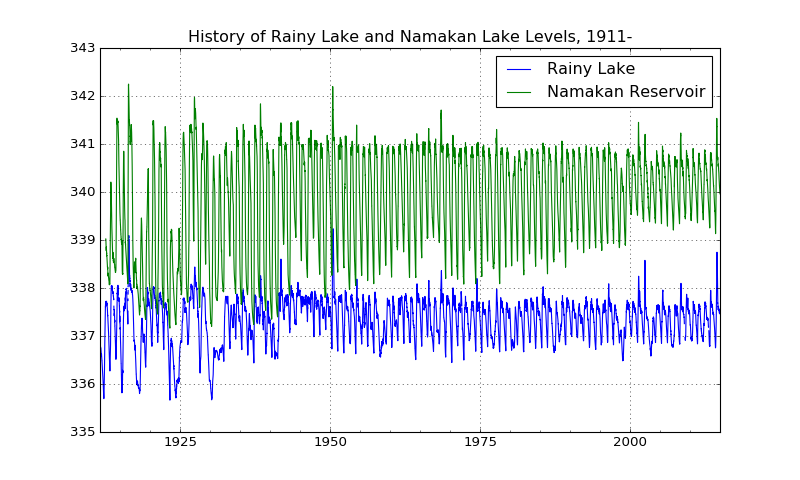

In [36]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

plt.figure(figsize=(10,6))
plt.hold(True)
WSC_LEVELS['05PB007'].plot(color='blue')   # RL at Fort Frances
WSC_LEVELS['05PA003'].plot(color='green')  # NL at Kettle Falls
WSC_LEVELS['05PA013'].plot(color='green')  # NL at Squirrel Island

plt.hold(False)
plt.legend(['Rainy Lake','Namakan Reservoir']);
plt.title('History of Rainy Lake and Namakan Lake Levels, 1911-')
plt.grid()

### Example: Distribution of Flows on Rainy River

The use of this function is demonstrated by creating a historgram of flows on Rainy River in the period 

In [87]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

RR = WSC_FLOWS['05PC019']
RM = WSC_FLOWS['05PC018']

<IPython.core.display.Javascript object>


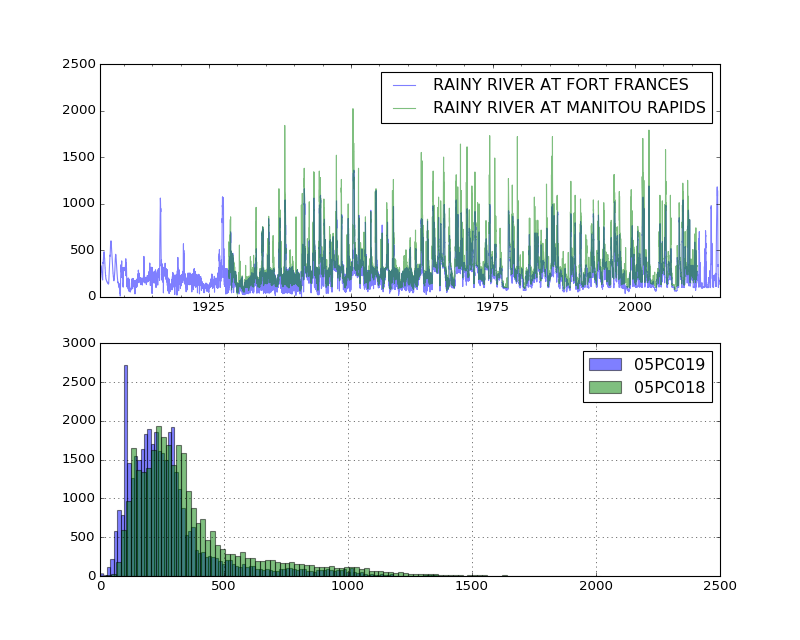

In [88]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hold(True)
RR.plot(alpha=0.5)
RM.plot(alpha=0.5)
plt.legend([WSC_STATIONS.ix[RR.name,'STATION_NAME'],WSC_STATIONS.ix[RM.name,'STATION_NAME']])
plt.hold(False)
plt.subplot(2,1,2)
plt.hold(True)
RR.hist(bins=100,alpha=0.5)
RM.hist(bins=100,alpha=0.5)
plt.hold(False)
plt.legend([RR.name,RM.name])


### Example: Estimating Inflows to Rainy River

<IPython.core.display.Javascript object>


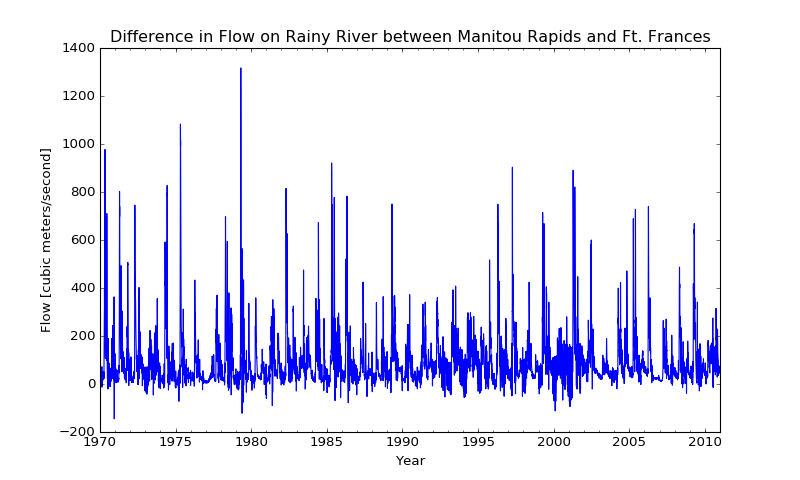

In [328]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

A = '05PC019'   # Rainy River at Ft. Frances
B = '05PC018'   # Rainy River at Manitou Rapids

FLOW = (WSC_FLOWS[B] - WSC_FLOWS[A]).dropna()

plt.figure(figsize=(10,6))
FLOW['1970':].plot()

plt.xlabel('Year')
plt.ylabel('Flow [cubic meters/second]')
plt.title('Difference in Flow on Rainy River between Manitou Rapids and Ft. Frances')

<IPython.core.display.Javascript object>


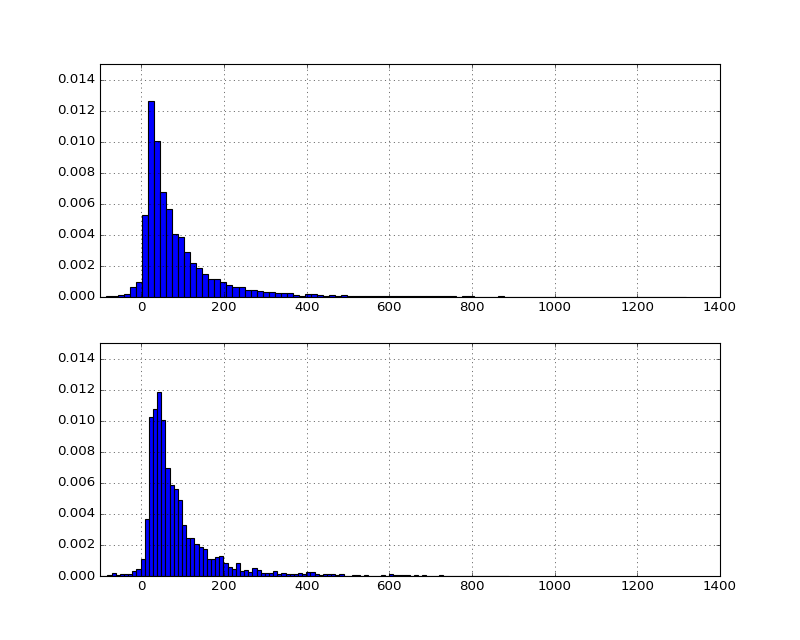

(-100, 1400)

In [329]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
FLOW['1970':'1999'].hist(bins=100,normed=1)
plt.ylim([0,.015])
plt.xlim([-100,1400])

plt.subplot(2,1,2)
FLOW['2000':].hist(bins=100,normed=1)
plt.ylim([0,.015])
plt.xlim([-100,1400])

<IPython.core.display.Javascript object>


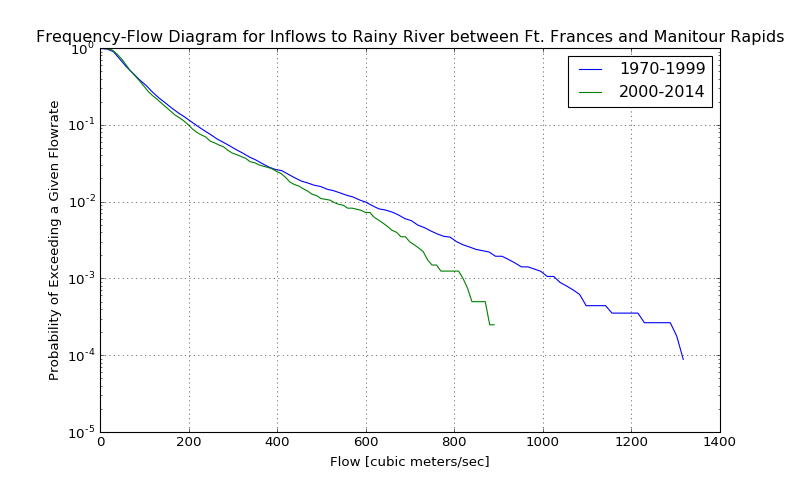

In [331]:
plt.figure(figsize=(10,6))

FLOW = WSC_FLOWS[B] - WSC_FLOWS[A]

plt.hold(True)

hist,bins = np.histogram([q for q in FLOW['1970':'2000'] if pd.notnull(q)],
                         bins = 100)
chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
plt.semilogy(bins[1:],chist)

plt.hold(True)
hist,bins = np.histogram([q for q in FLOW['2000':] if pd.notnull(q)],
                         bins = 100)
chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
plt.semilogy(bins[1:],chist)
plt.xlim([0,plt.xlim()[1]])

plt.xlim([0,plt.xlim()[1]])

plt.legend(['1970-1999','2000-2014'])

plt.ylabel('Probability of Exceeding a Given Flowrate')
plt.xlabel('Flow [cubic meters/sec]')
plt.title('Frequency-Flow Diagram for Inflows to Rainy River between Ft. Frances and Manitour Rapids')

plt.hold(False)
plt.grid()


### Example: Flow-Frequency Behaviors for State-of-Nature Streams in the Rainy River Watershed

In [79]:
# read data sets
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

WSC_STATIONS.loc[WSC_STATIONS['Flow']==True]['STATION_NAME']

STATION_NUMBER
05PA001                     KETTLE RIVER ABOVE KETTLE FALLS
05PA006             NAMAKAN RIVER AT OUTLET OF LAC LA CROIX
05PA012                          BASSWOOD RIVER NEAR WINTON
05PB001                           SEINE RIVER NEAR LA SEINE
05PB003                 MANITOU RIVER ABOVE DEVIL'S CASCADE
05PB004                 FOOTPRINT RIVER AT RAINY LAKE FALLS
05PB009    SEINE RIVER AT STURGEON FALLS GENERATING STATION
05PB014                       TURTLE RIVER NEAR MINE CENTRE
05PB015                    PIPESTONE RIVER ABOVE RAINY LAKE
05PB018                          ATIKOKAN RIVER AT ATIKOKAN
05PB019    NORTHEAST TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN
05PB020      EASTERN TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN
05PB021      EYE RIVER NEAR HARDTACK LAKE NORTH OF ATIKOKAN
05PB022       EYE RIVER NEAR COULSON LAKE NORTH OF ATIKOKAN
05PC009                        LA VALLEE RIVER AT LA VALLEE
05PC010                         STURGEON RIVER NEAR BARWICK
05PC016                  

05PA006 NAMAKAN RIVER AT OUTLET OF LAC LA CROIX            1921 2014
05PA012 BASSWOOD RIVER NEAR WINTON                         1924 2010
05PB001 SEINE RIVER NEAR LA SEINE                          1914 1926
05PB003 MANITOU RIVER ABOVE DEVIL'S CASCADE                1914 1915
05PB004 FOOTPRINT RIVER AT RAINY LAKE FALLS                1914 1916
05PB009 SEINE RIVER AT STURGEON FALLS GENERATING STATION   1963 2014
05PB014 TURTLE RIVER NEAR MINE CENTRE                      1914 2014
05PB015 PIPESTONE RIVER ABOVE RAINY LAKE                   1963 1998
05PB018 ATIKOKAN RIVER AT ATIKOKAN                         1978 2014
05PB019 NORTHEAST TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN   1986 1986
05PB020 EASTERN TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN     1986 1986
05PB021 EYE RIVER NEAR HARDTACK LAKE NORTH OF ATIKOKAN     1985 1994
05PB022 EYE RIVER NEAR COULSON LAKE NORTH OF ATIKOKAN      1985 1993
05PC009 LA VALLEE RIVER AT LA VALLEE                       1952 1959
05PC010 STURGEON RIVER NEAR BARWIC

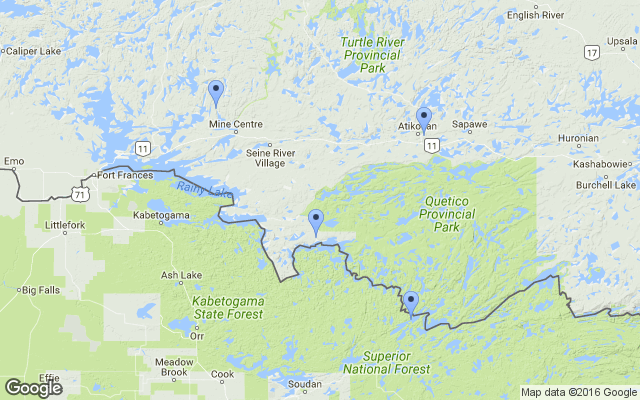

05PA006 NAMAKAN RIVER AT OUTLET OF LAC LA CROIX            1921 2014
05PA012 BASSWOOD RIVER NEAR WINTON                         1924 2010
05PB014 TURTLE RIVER NEAR MINE CENTRE                      1914 2014
05PB018 ATIKOKAN RIVER AT ATIKOKAN                         1978 2014


<IPython.core.display.Javascript object>


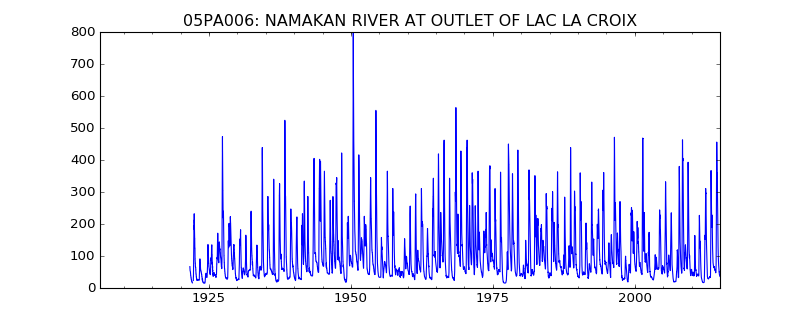

<IPython.core.display.Javascript object>


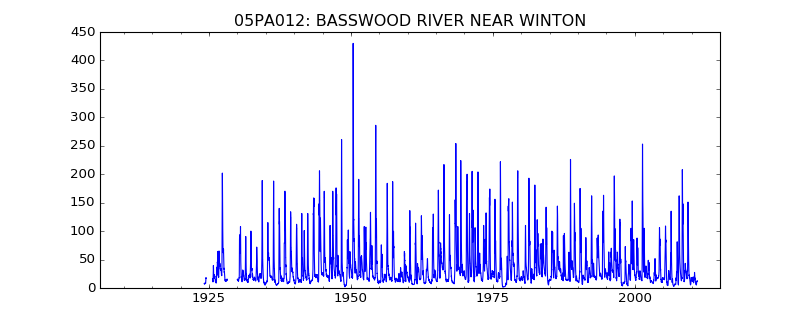

<IPython.core.display.Javascript object>


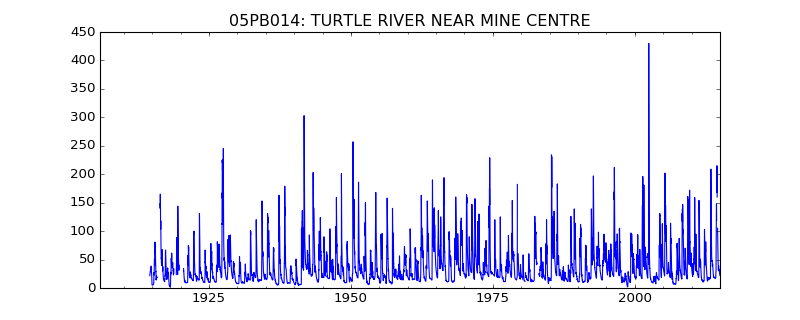

<IPython.core.display.Javascript object>


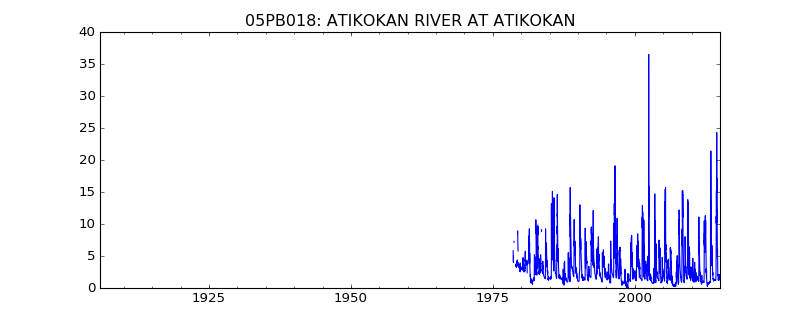

In [148]:
stationList = ['05PA006','05PA012','05PB001','05PB003','05PB004','05PB009',
               '05PB014','05PB015','05PB018','05PB019','05PB020','05PB021',
               '05PB022','05PC009','05PC010','05PC016','05PC022']

for s in stationList:
    print s,
    print "{0:50s}".format(WSC_STATIONS.loc[s]['STATION_NAME']),
    print WSC_FLOWS[s].dropna().index[0].year,
    print WSC_FLOWS[s].dropna().index[-1].year
    
stationList = ['05PA006','05PA012','05PB014','05PB018']
display(mapWSC(stationList))

for s in stationList:
    print s,
    print "{0:50s}".format(WSC_STATIONS.loc[s]['STATION_NAME']),
    print WSC_FLOWS[s].dropna().index[0].year,
    print WSC_FLOWS[s].dropna().index[-1].year

for s in stationList:
    plt.figure(figsize=(10,4))
    WSC_FLOWS[s].plot()
    plt.title(s + ': ' + WSC_STATIONS.loc[s]['STATION_NAME'])

STATION_NAME            NAMAKAN RIVER AT OUTLET OF LAC LA CROIX
PROV_TERR_STATE_LOC                                          ON
REGIONAL_OFFICE_ID                                            5
HYD_STATUS                                                    A
SED_STATUS                                                  NaN
LATITUDE                                                48.3826
LONGITUDE                                              -92.1763
DRAINAGE_AREA_GROSS                                       13400
DRAINAGE_AREA_EFFECT                                        NaN
RHBN                                                          0
REAL_TIME                                                     1
CONTRIBUTOR_ID                                              647
OPERATOR_ID                                                 647
DATUM_ID                                                     95
Level                                                      True
Flow                                    

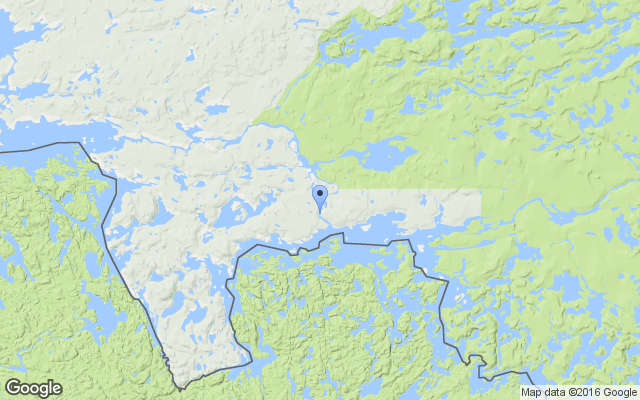

<IPython.core.display.Javascript object>


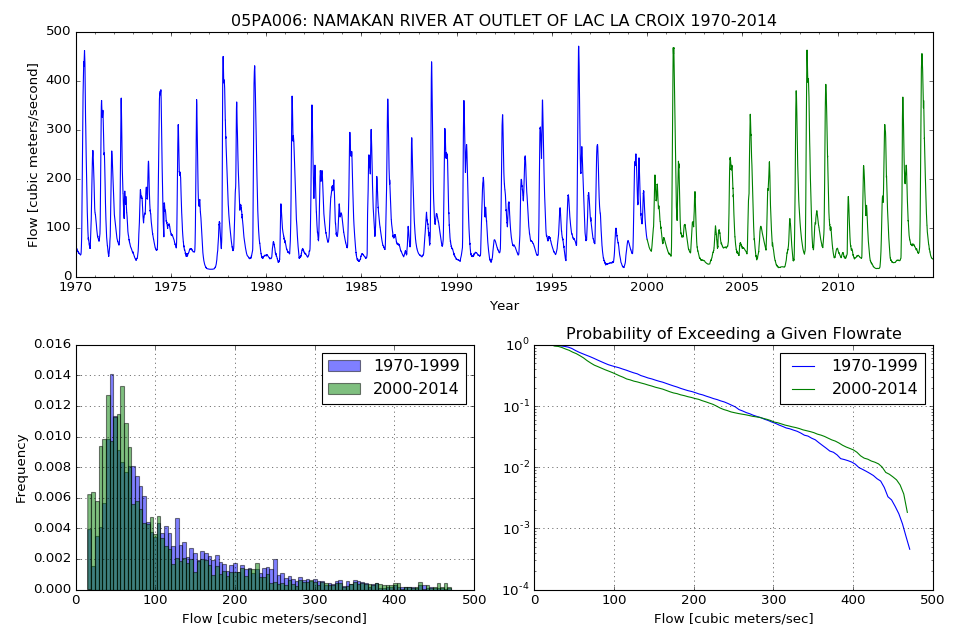

STATION_NAME            BASSWOOD RIVER NEAR WINTON
PROV_TERR_STATE_LOC                             ON
REGIONAL_OFFICE_ID                               5
HYD_STATUS                                       A
SED_STATUS                                     NaN
LATITUDE                                   48.0826
LONGITUDE                                 -91.6512
DRAINAGE_AREA_GROSS                           4510
DRAINAGE_AREA_EFFECT                           NaN
RHBN                                             0
REAL_TIME                                        0
CONTRIBUTOR_ID                                 647
OPERATOR_ID                                    600
DATUM_ID                                        10
Level                                         True
Flow                                          True
Name: 05PA012, dtype: object

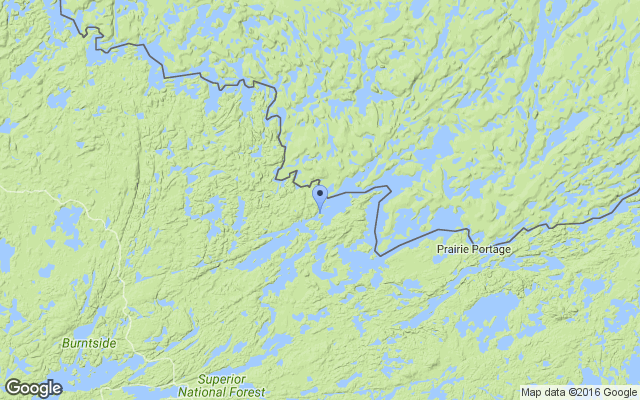

<IPython.core.display.Javascript object>


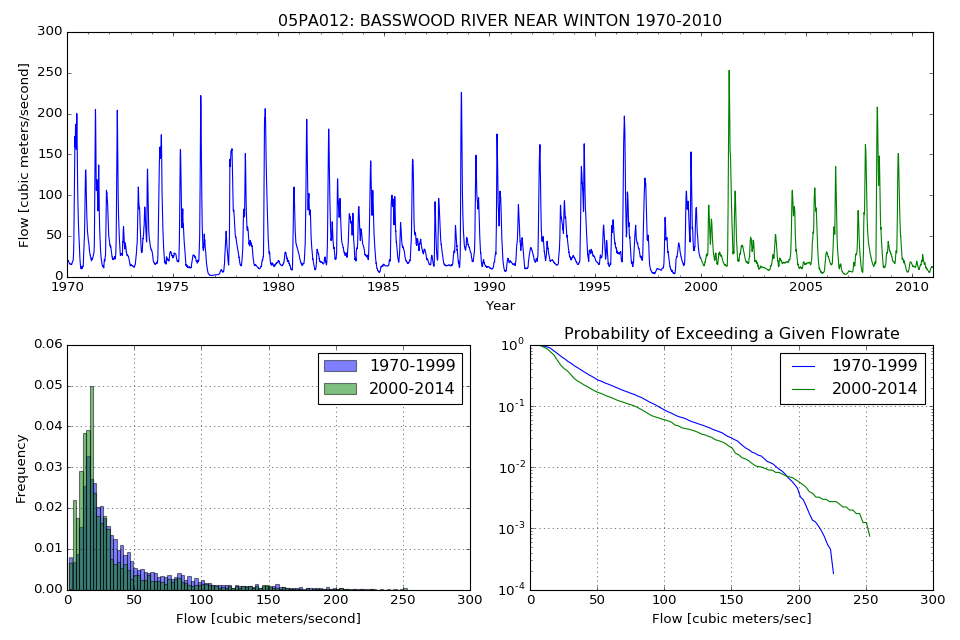

STATION_NAME            TURTLE RIVER NEAR MINE CENTRE
PROV_TERR_STATE_LOC                                ON
REGIONAL_OFFICE_ID                                  5
HYD_STATUS                                          A
SED_STATUS                                        NaN
LATITUDE                                      48.8502
LONGITUDE                                    -92.7238
DRAINAGE_AREA_GROSS                           4767.74
DRAINAGE_AREA_EFFECT                              NaN
RHBN                                                1
REAL_TIME                                           1
CONTRIBUTOR_ID                                    647
OPERATOR_ID                                       647
DATUM_ID                                           10
Level                                            True
Flow                                             True
Name: 05PB014, dtype: object

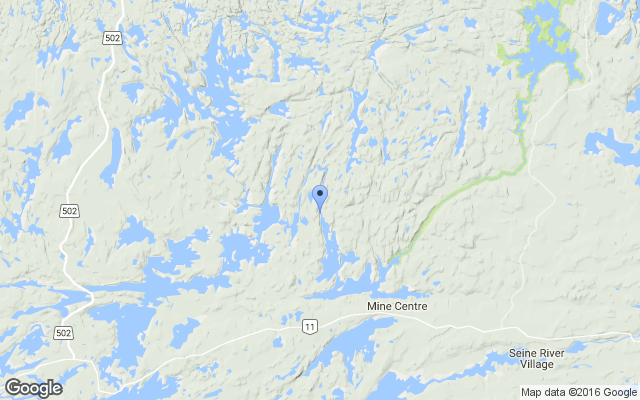

<IPython.core.display.Javascript object>


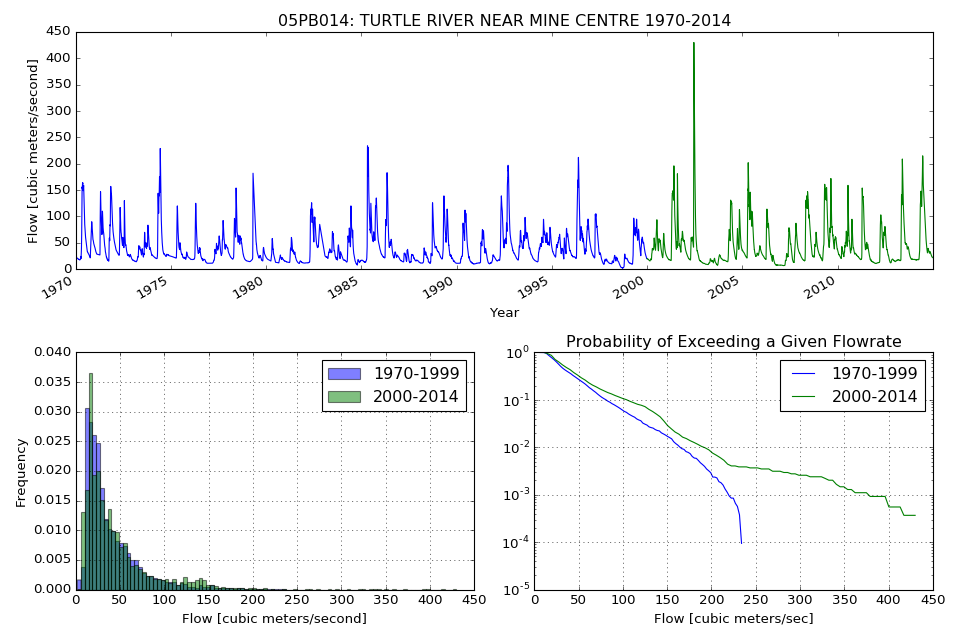

STATION_NAME            ATIKOKAN RIVER AT ATIKOKAN
PROV_TERR_STATE_LOC                             ON
REGIONAL_OFFICE_ID                               5
HYD_STATUS                                       A
SED_STATUS                                     NaN
LATITUDE                                    48.752
LONGITUDE                                 -91.5841
DRAINAGE_AREA_GROSS                         358.02
DRAINAGE_AREA_EFFECT                           NaN
RHBN                                             0
REAL_TIME                                        1
CONTRIBUTOR_ID                                 480
OPERATOR_ID                                    647
DATUM_ID                                       129
Level                                         True
Flow                                          True
Name: 05PB018, dtype: object

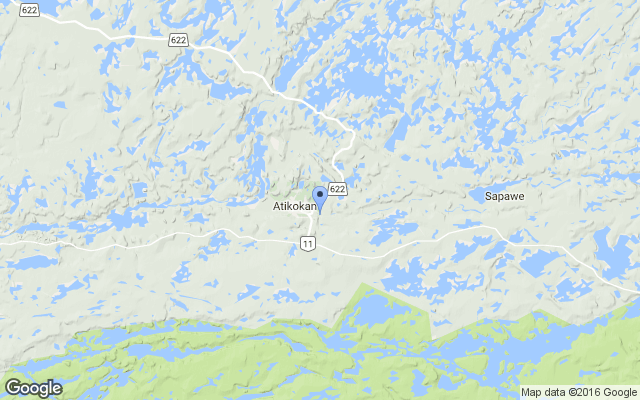

<IPython.core.display.Javascript object>


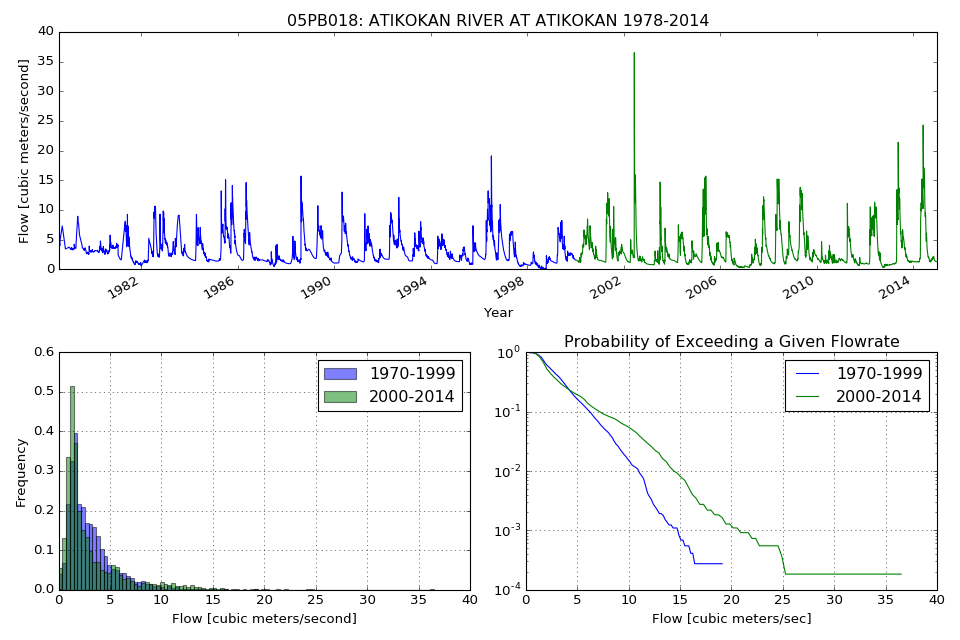

In [147]:
def WSC_FlowFrequency(s):
    
    display(WSC_STATIONS.ix[s])
    display(mapWSC([s],10))
    

    FLOW = WSC_FLOWS[s]['1970':].dropna()
    # select period of year
    FLOW = FLOW.ix[FLOW.index.dayofyear >= 1] # 135]
    FLOW = FLOW.ix[FLOW.index.dayofyear <= 366] # 196]

    # show data
    plt.figure(figsize=(12,8))
    plt.subplot2grid((2,2),(0,0),colspan=2)
    FLOW[:'1999'].plot(color='b')
    plt.hold(True)
    FLOW['2000':].plot(color='g')    
    plt.xlabel('Year')
    plt.ylabel('Flow [cubic meters/second]')
    plt.title(s + ': ' + WSC_STATIONS.ix[s,'STATION_NAME'] + 
              ' ' + str(FLOW.index[0].year) + '-' + str(FLOW.index[-1].year))
    
    # histogram distribution of flows
    plt.subplot2grid((2,2),(1,0))
    plt.hold(True)
    hist,bins = np.histogram(FLOW,bins=100)
    FLOW['1970':'1999'].hist(bins=bins,normed=1, color='b', alpha=0.5)
    FLOW['2000':].hist(bins=bins,normed=1,color='g', alpha=0.5)
    plt.ylabel('Frequency')
    plt.xlabel('Flow [cubic meters/second]')
    plt.legend(['1970-1999','2000-2014'])
    plt.tight_layout()
    
    # flow-frequency plots
    plt.subplot2grid((2,2),(1,1))
    plt.hold(True)
    hist,bins = np.histogram(FLOW['1970':'1999'],bins = 100)
    chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
    plt.semilogy(bins[1:],chist)
    hist,bins = np.histogram(FLOW['2000':],bins = 100)
    chist = np.cumsum(hist[::-1])[::-1]/float(sum(hist))
    plt.semilogy(bins[1:],chist,color='g')
    plt.xlim([0,plt.xlim()[1]])
    plt.legend(['1970-1999','2000-2014'])
    plt.title('Probability of Exceeding a Given Flowrate')
    plt.xlabel('Flow [cubic meters/sec]')

    plt.hold(False)
    plt.grid()
    plt.tight_layout()
    
    fname = '../images/FlowFrequency_' + s + '.png'
    plt.savefig(fname)
    !convert $fname -trim $fname


    
for s in stationList:
    WSC_FlowFrequency(s)

### Annual flows on Rainy River

<IPython.core.display.Javascript object>


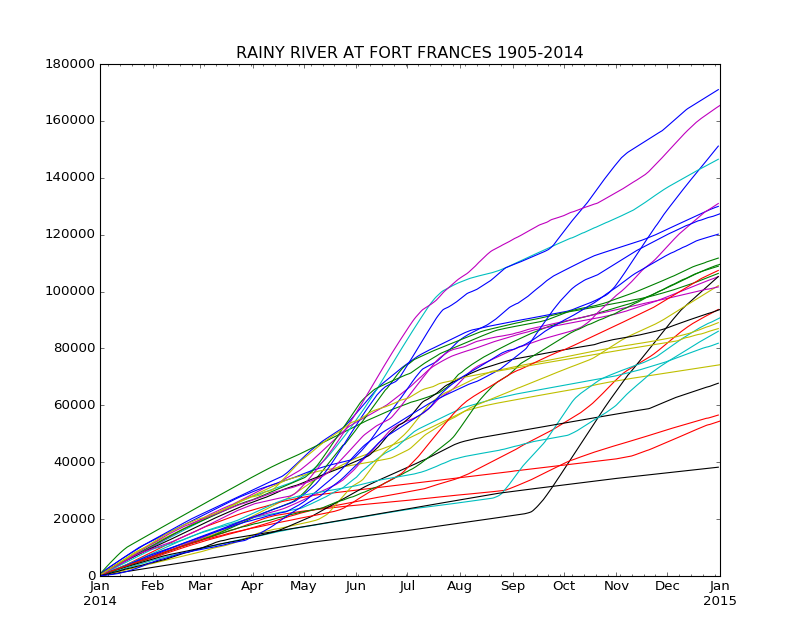

<IPython.core.display.Javascript object>


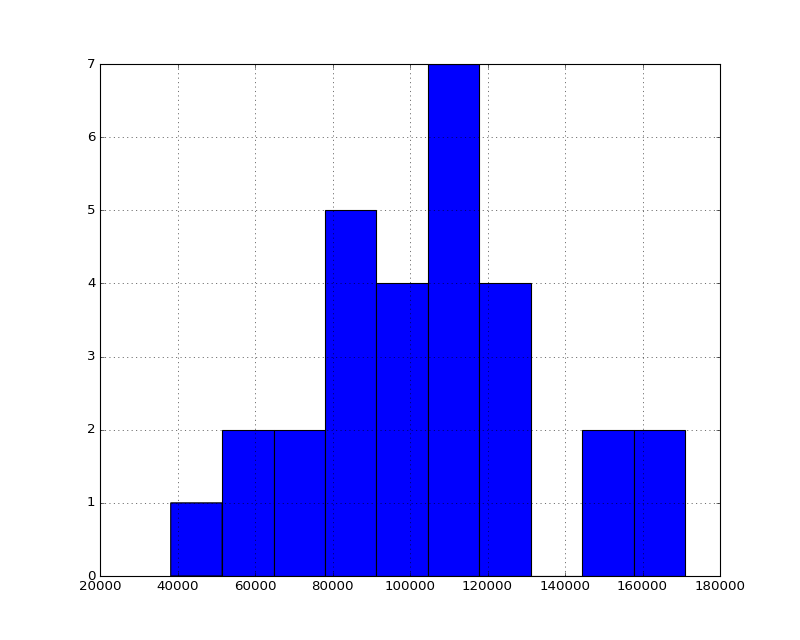

In [107]:
WSC_STATIONS = pd.read_pickle('../data/WSC_STATIONS')
WSC_LEVELS = pd.read_pickle('../data/WSC_LEVELS')
WSC_FLOWS = pd.read_pickle('../data/WSC_FLOWS')

FLOW = WSC_FLOWS['05PC019']

plt.figure(figsize=(10,8))
plt.subplot(1,1,1)
plt.hold(True)

yrA = str(WSC_FLOWS[s].dropna().index[0].year)
yrB = str(WSC_FLOWS[s].dropna().index[-1].year)
plt.title(WSC_STATIONS.ix[s,'STATION_NAME']
          + ' ' + str(WSC_FLOWS[s].dropna().index[0].year) 
          + '-' + str(WSC_FLOWS[s].dropna().index[-1].year)) 

for (yr,r) in FLOW['1971':'1999'].groupby(FLOW['1971':'1999'].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.cumsum().plot()

    
plt.figure(figsize=(10,8))
FLOW['1970':'1999'].plot()

plt.grid()
    
plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

#fname = img + 'RuleCurvePerformance1970-1999.png'

#plt.savefig(fname)
#!convert $fname -trim $fname


<IPython.core.display.Javascript object>


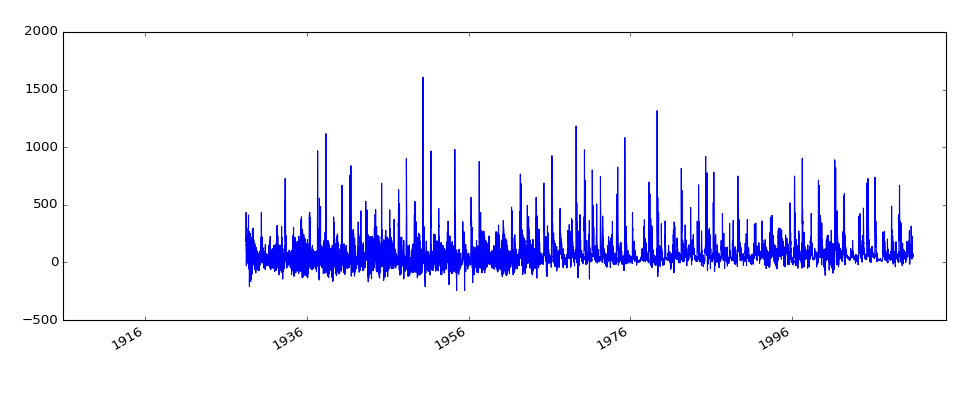

In [251]:
plt.figure(figsize=(12,5))
F = FLOW['1970':].groupby(FLOW['1970':].index.year).mean()



import statsmodels.api as sm

x = F.index
y = F.values

x = sm.add_constant(x)
est = sm.OLS(y,x).fit()
est.summary()

ypred = est.params[0] + F.index*est.params[1]

plt.hold(True)
ax = F.plot(kind='bar',color='b',alpha=0.5)
ax.plot(ax.get_xticks(),ypred,'r--')
plt.hold(False)

plt.title('Mean Annual Flow on Rainy River at Ft. Frances')
plt.xlabel('Year')
plt.ylabel('Cubic Meters per Second')

plt.tight_layout()

In [241]:
[x,y,ypred]

[array([[  1.00000000e+00,   1.97000000e+03],
        [  1.00000000e+00,   1.97100000e+03],
        [  1.00000000e+00,   1.97200000e+03],
        [  1.00000000e+00,   1.97300000e+03],
        [  1.00000000e+00,   1.97400000e+03],
        [  1.00000000e+00,   1.97500000e+03],
        [  1.00000000e+00,   1.97600000e+03],
        [  1.00000000e+00,   1.97700000e+03],
        [  1.00000000e+00,   1.97800000e+03],
        [  1.00000000e+00,   1.97900000e+03],
        [  1.00000000e+00,   1.98000000e+03],
        [  1.00000000e+00,   1.98100000e+03],
        [  1.00000000e+00,   1.98200000e+03],
        [  1.00000000e+00,   1.98300000e+03],
        [  1.00000000e+00,   1.98400000e+03],
        [  1.00000000e+00,   1.98500000e+03],
        [  1.00000000e+00,   1.98600000e+03],
        [  1.00000000e+00,   1.98700000e+03],
        [  1.00000000e+00,   1.98800000e+03],
        [  1.00000000e+00,   1.98900000e+03],
        [  1.00000000e+00,   1.99000000e+03],
        [  1.00000000e+00,   1.991

In [199]:
ypred = est.params[0] + (F.index - 2000)*est.params[1]
ypred

Float64Index([0.964273161183,  0.96183014142, 0.959387121657, 0.956944101894,
              0.954501082131, 0.952058062368, 0.949615042606, 0.947172022843,
               0.94472900308, 0.942285983317, 0.939842963554, 0.937399943791,
              0.934956924028, 0.932513904266, 0.930070884503,  0.92762786474,
              0.925184844977, 0.922741825214, 0.920298805451, 0.917855785689,
              0.915412765926, 0.912969746163,   0.9105267264, 0.908083706637,
              0.905640686874, 0.903197667111, 0.900754647349, 0.898311627586,
              0.895868607823,  0.89342558806, 0.890982568297, 0.888539548534,
              0.886096528772, 0.883653509009, 0.881210489246, 0.878767469483,
               0.87632444972, 0.873881429957, 0.871438410194, 0.868995390432,
              0.866552370669, 0.864109350906, 0.861666331143,  0.85922331138,
              0.856780291617],
             dtype='float64')

In [171]:
regressors = sm.tools.tools.add_constant(x)
r = sm.OLS(y,regressors).fit()

print r.summary()

                            OLS Regression Results                            
Dep. Variable:                05PC019   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5558
Date:                Thu, 04 Aug 2016   Prob (F-statistic):              0.460
Time:                        14:59:34   Log-Likelihood:                -6.4195
No. Observations:                  45   AIC:                             16.84
Df Residuals:                      43   BIC:                             20.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.7770      6.528      0.885      0.3

<IPython.core.display.Javascript object>


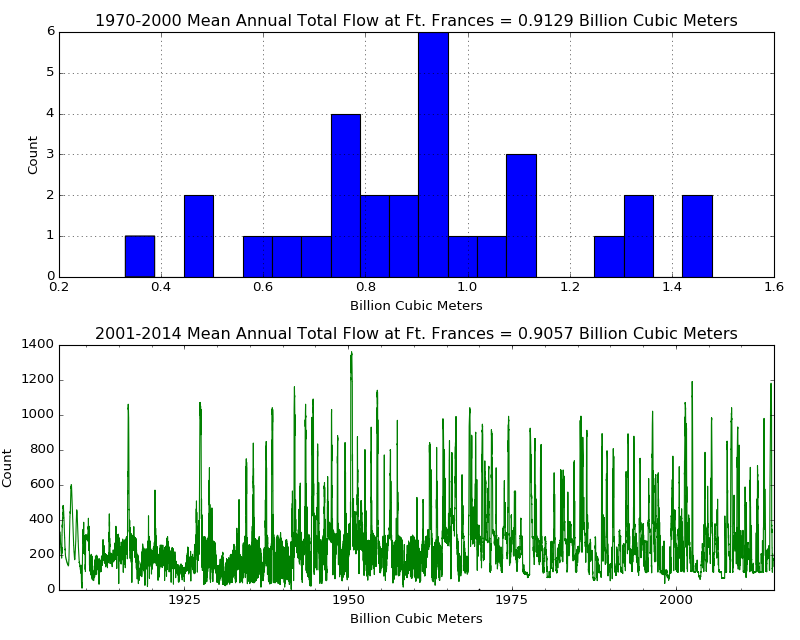

In [153]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

A = FLOW['1970':'1999']
B = FLOW['2000':]

totalflow = 24*3600*A.groupby(A.index.year).sum()/10e9
totalflow.hist(bins=20)
plt.title('1970-2000 Mean Annual Total Flow at Ft. Frances = ' + "{:5.4f}".format(totalflow.mean()) + ' Billion Cubic Meters')
plt.xlabel('Billion Cubic Meters')
plt.ylabel('Count')

plt.subplot(2,1,2)
totalflow = 24*3600*B.groupby(B.index.year).sum()/10e9
totalflow.hist(bins=20)
plt.title('2001-2014 Mean Annual Total Flow at Ft. Frances = ' + "{:5.4f}".format(totalflow.mean()) + ' Billion Cubic Meters')
plt.xlabel('Billion Cubic Meters')
plt.ylabel('Count')

plt.tight_layout()

<IPython.core.display.Javascript object>


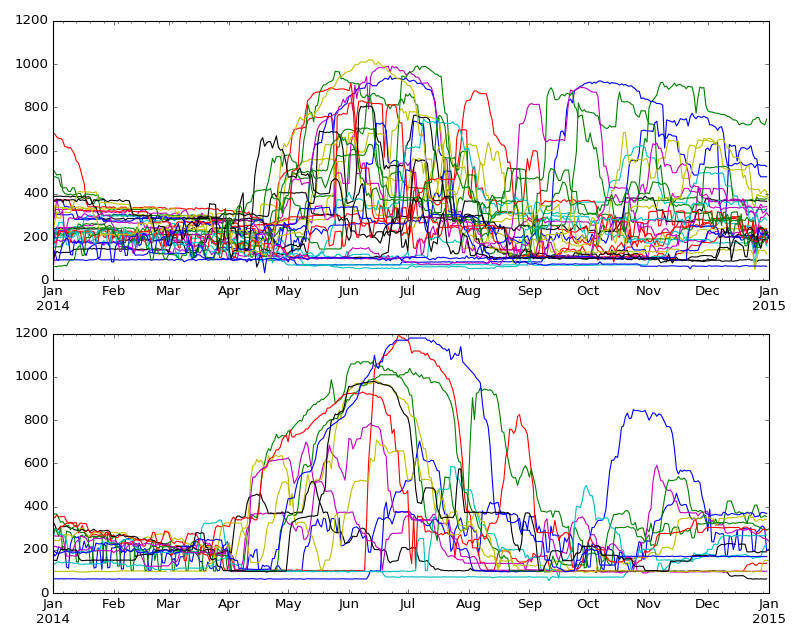

In [151]:
plt.figure(figsize=(10,8))

A = FLOW['1970':'1999']
B = FLOW['2000':]

plt.subplot(2,1,1)
plt.hold(True)
for (yr,r) in A.groupby(A.index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()
    
plt.subplot(2,1,2)
plt.hold(True)
for (yr,r) in B.groupby(B.index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()

plt.tight_layout()

<IPython.core.display.Javascript object>


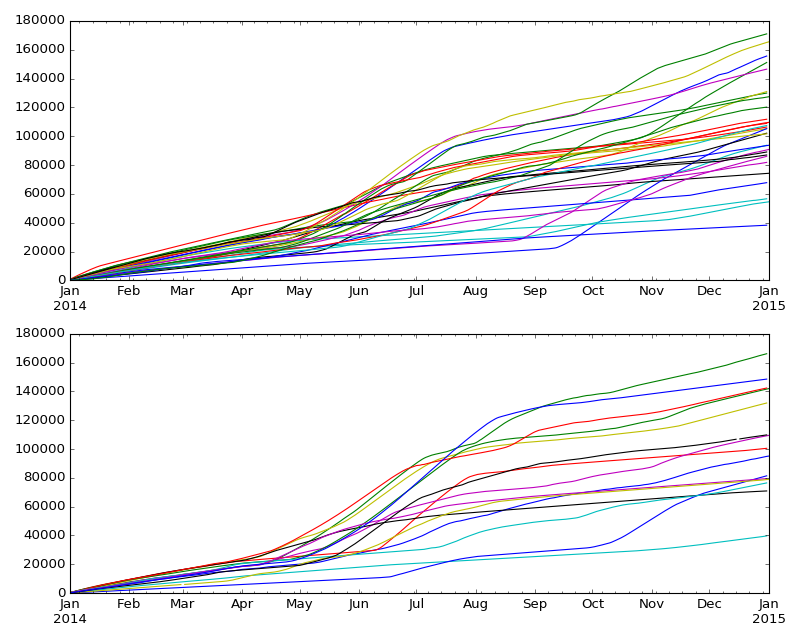

In [152]:
plt.figure(figsize=(10,8))

A = FLOW['1970':'1999']
B = FLOW['2000':]

plt.subplot(2,1,1)
plt.hold(True)
for (yr,r) in A.groupby(A.index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.cumsum().plot()
    
plt.subplot(2,1,2)
plt.hold(True)
for (yr,r) in B.groupby(B.index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.cumsum().plot()

plt.tight_layout()

In [121]:
tf.mean()

103645.49333333333

## Create `hydat.h5` Data Cache

Reading the entire HYDAT database is a lengthy operation, and because of file size constraints, the entire data set can not be stored in a github repository or hosted on a docker server. For those reaaons, the an HDF5 data cache is created in the local repository to include selected data relevant to the Rainy/Namakan system.

In [ ]:
t

In [11]:
from os.path import isfile
from os import remove

if isfile('../data/hydat.h5'):
    print 'Delete old ../data/hydat.h5'
    remove('../data/hydat.h5')
    
print 'Creating new ../data/hydat.h5'
hydat = pd.HDFStore('../data/hydat.h5')
    
# store data in hydat.h5
hydat['STATIONS'] = STATIONS.ix[stationList].groupby(level=0).last()
hydat['DLY_FLOWS'] = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'].isin(flowStations)]
hydat['DLY_LEVELS'] = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'].isin(levelStations)]

print hydat
hydat.close()
print hydat

/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['STATION_NUMBER', 'FLOW_SYMBOL1', 'FLOW_SYMBOL2', 'FLOW_SYMBOL3', 'FLOW_SYMBOL4', 'FLOW_SYMBOL5', 'FLOW_SYMBOL6', 'FLOW_SYMBOL7', 'FLOW_SYMBOL8', 'FLOW_SYMBOL9', 'FLOW_SYMBOL10', 'FLOW_SYMBOL11', 'FLOW_SYMBOL12', 'FLOW_SYMBOL13', 'FLOW_SYMBOL14', 'FLOW_SYMBOL15', 'FLOW_SYMBOL16', 'FLOW_SYMBOL17', 'FLOW_SYMBOL18', 'FLOW_SYMBOL19', 'FLOW_SYMBOL20', 'FLOW_SYMBOL21', 'FLOW_SYMBOL22', 'FLOW_SYMBOL23', 'FLOW_SYMBOL24', 'FLOW_SYMBOL25', 'FLOW_SYMBOL26', 'FLOW_SYMBOL27', 'FLOW_SYMBOL28', 'FLOW_SYMBOL29', 'FLOW_SYMBOL30', 'FLOW_SYMBOL31']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTabl

Delete old ../data/hydat.h5
Creating new ../data/hydat.h5
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
/DLY_FLOWS             frame        (shape->[7965,73])
/DLY_LEVELS            frame        (shape->[5913,74])
/STATIONS              frame        (shape->[34,14])  
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
File is CLOSED


## Reading `hydat.h5` Data Cache

In [13]:
from os.path import isfile
hydat = pd.HDFStore('../data/hydat.h5')

# reload from cache (to verify data round trip)
STATIONS = hydat['STATIONS']
DLY_LEVELS = hydat['DLY_LEVELS']
DLY_FLOWS = hydat['DLY_FLOWS']

print hydat
hydat.close()
print hydat

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
/DLY_FLOWS             frame        (shape->[7965,73])
/DLY_LEVELS            frame        (shape->[5913,74])
/STATIONS              frame        (shape->[34,14])  
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
File is CLOSED


<!--NAVIGATION-->
< [Ice Out Dates](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.08-Ice_Out_Dates.ipynb) | [Contents](toc.ipynb) | [Rainy River Flows](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.20-Rainy_River_Flows.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/A.09-USGS Surface Water Daily Data.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/A.09-USGS Surface Water Daily Data.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>